In [1]:

import numpy as np
from skimage.color import rgb2gray,rgba2rgb
from skimage.measure import find_contours
from skimage import transform, feature, color , morphology , measure, segmentation, filters, draw, io
from commonfunctions import * 
from skimage.draw import rectangle

%matplotlib inline
%load_ext autoreload
%autoreload 2


## Read Imag and handle its orientation

In [2]:
# Read the imag

def deskew_image(img):
    # Read the image
    image = np.copy(img)
    gray = color.rgb2gray(image)

    # Apply edge detection using Canny
    edges = feature.canny(gray, sigma=1.0, low_threshold=0.1, high_threshold=0.9)

    # Use probabilistic Hough Transform to detect lines
    lines = transform.probabilistic_hough_line(edges, threshold=10, line_length=5, line_gap=3)

    # Determine the dominant angle of the lines
    angles = [np.arctan2((y2 - y1), (x2 - x1)) for (x1, y1), (x2, y2) in lines]
    dominant_angle = np.median(angles) * 180 / np.pi

    # Rotate the image to correct skewing and orientation
    rotated_image = transform.rotate(image, dominant_angle, resize=True)

    return rotated_image
# image 4,15 is the only one that is rotated wrong 

deskewed_images = list()

# for i in range(10,15):
#     image = io.imread('grade_sheet/{}.jpg'.format(i))
#     deskewed_image = deskew_image(image)
#     show_images([image,deskewed_image], ['image', 'deskewed_image'])
#     deskewed_images.append(deskewed_image)
    

## Crop the image

In [3]:
def draw_contours(img):
    # Apply Gaussian blur
    image = np.copy(img)
    
    blurred = color.rgb2gray(image)
    blurred = blurred > .5

    # Perform morphological operations to close gaps in edges
    blurred = morphology.closing(blurred, morphology.square(6))

    # Label connected components (no effect)
    label_image = measure.label(blurred)

    # Find contours using scikit-image
    cnts = measure.find_contours(label_image, .5)

    max_area = 0
    max_box = None
    for cnt in cnts:
        Xmin = int(round(min(cnt[:,1])))
        Xmax = int(round(max(cnt[:,1])))
        Ymin = int(round(min(cnt[:,0])))
        Ymax = int(round(max(cnt[:,0])))

        width = abs( Xmax - Xmin) 
        height = abs(Ymax - Ymin)
        area = width * height 
        
        if area > max_area:
            max_area = area 
            max_box = [Xmin, Xmax, Ymin, Ymax]

    [Xmin, Xmax, Ymin, Ymax] = max_box
    print(max_box)
    rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=image.shape)
    image[rr, cc] = [255,255,255] #set color white
    return max_box, image



# for i in range(1,10):
#     image = io.imread('grade_sheet/{}.jpg'.format(i))
#     blurred, mask = draw_contours(image)
#     sheet = mask
#     show_images([image,mask, sheet ], ['image', 'mask', 'sheet'])


[242, 2808, 148, 3706]


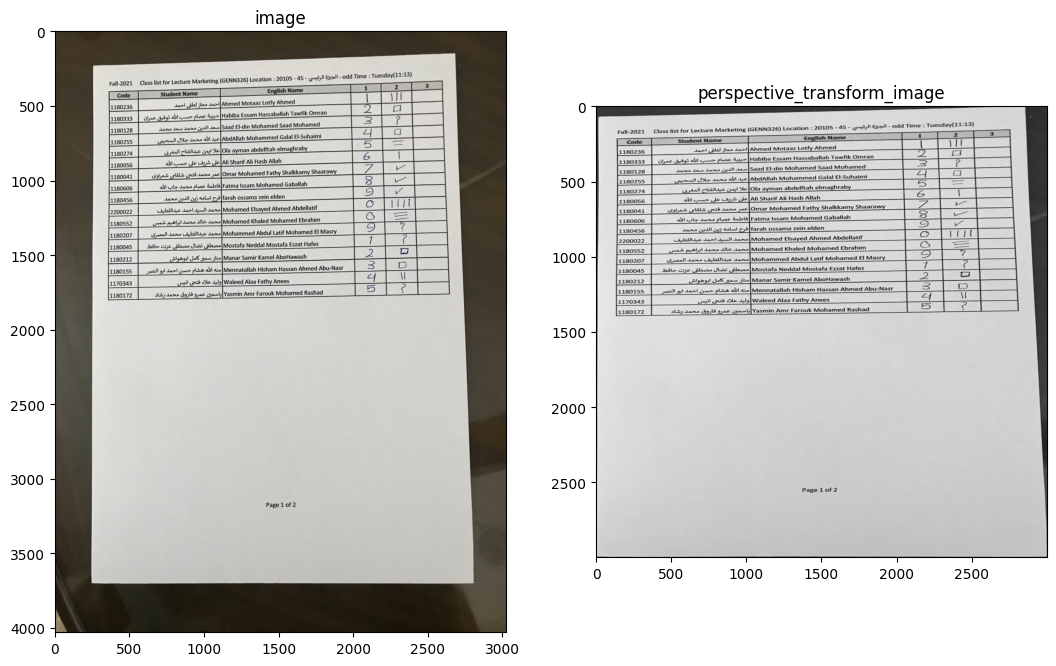

[42, 696, 62, 960]


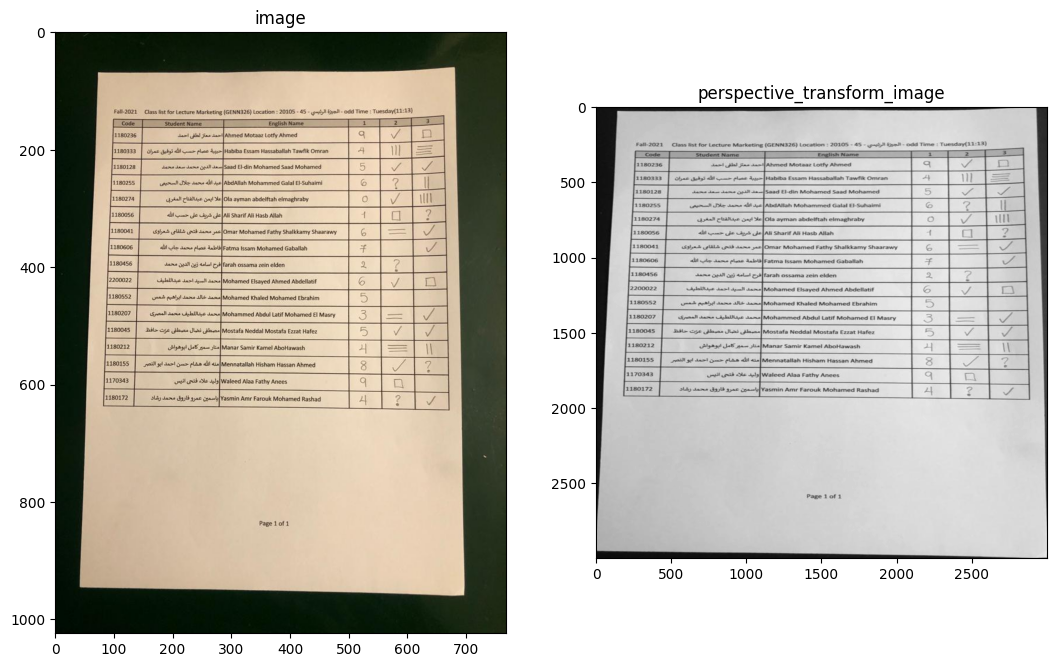

[8, 702, 24, 986]


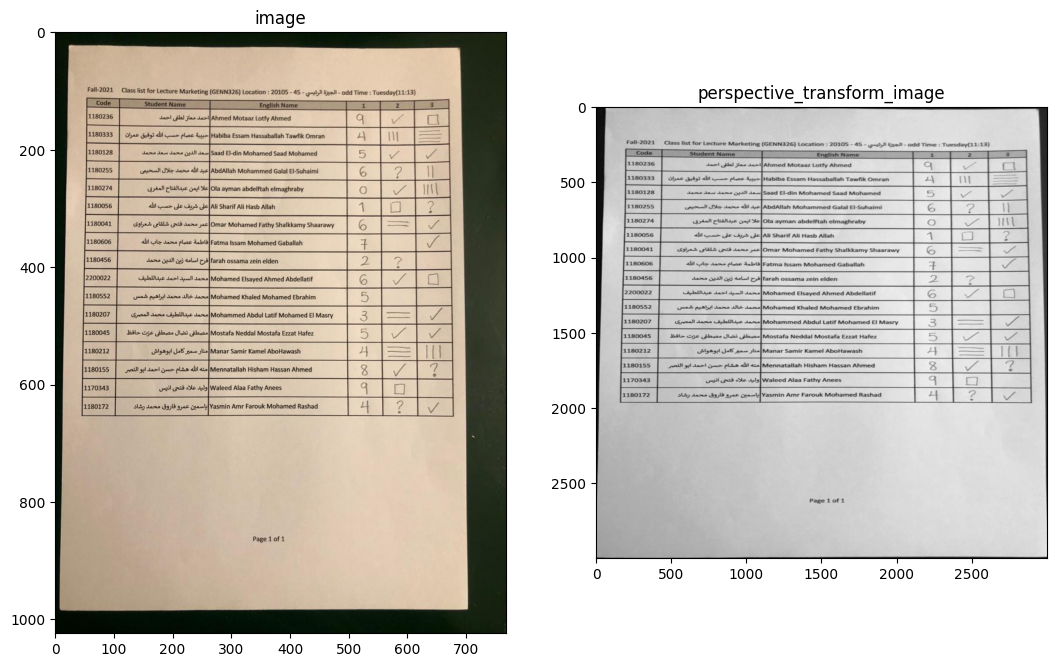

[66, 754, 52, 1002]


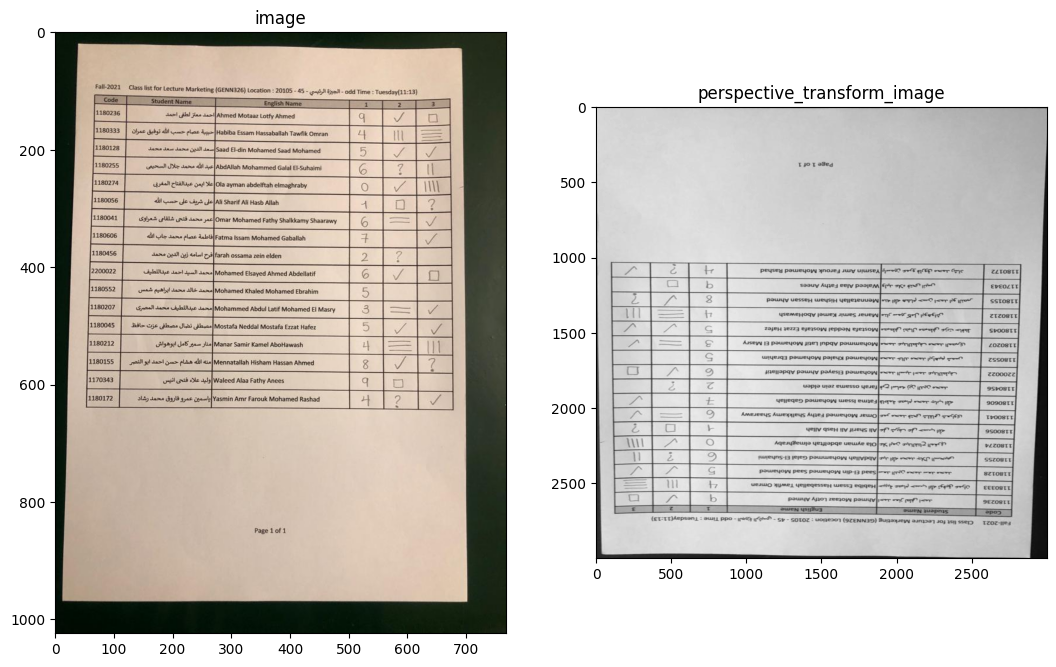

[163, 2868, 318, 3706]


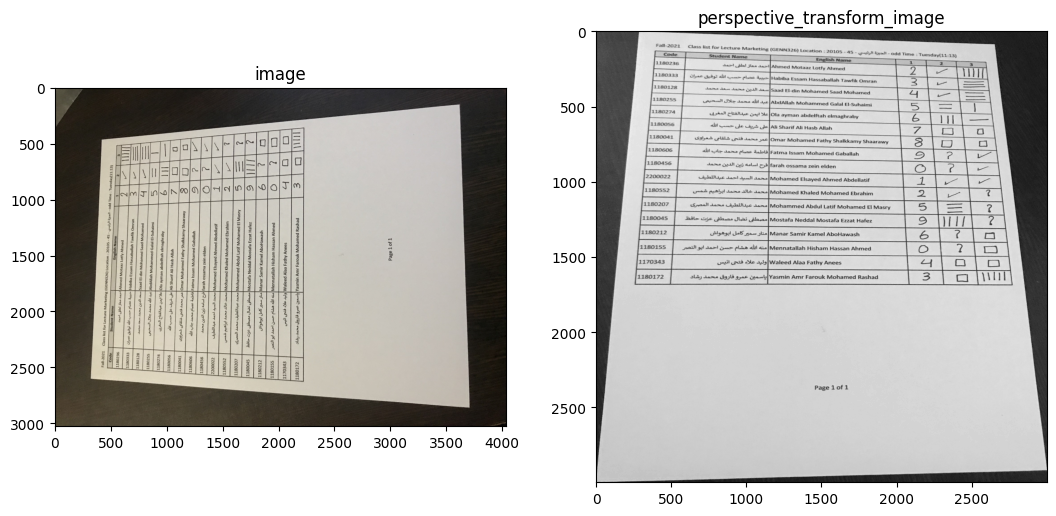

[244, 2873, 569, 3750]


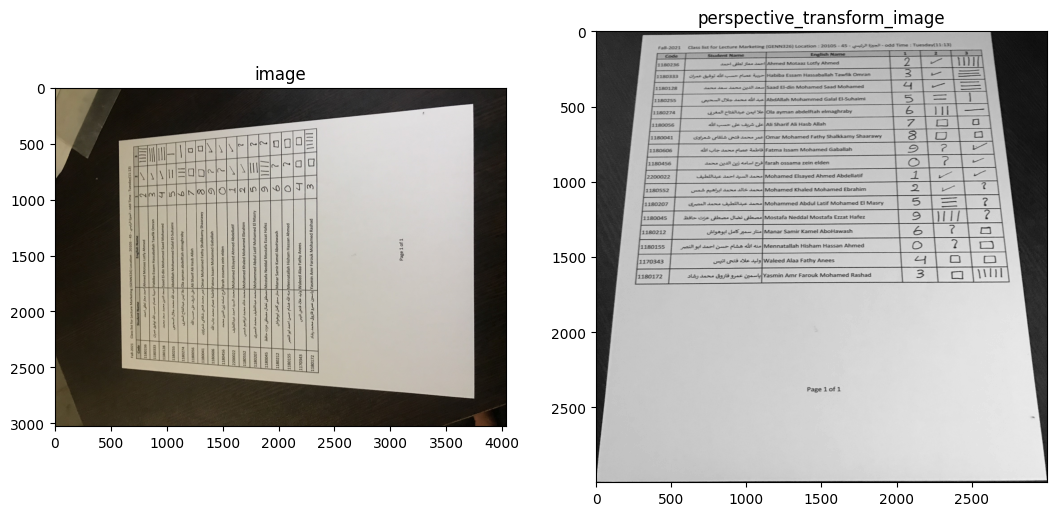

[436, 2983, 720, 3826]


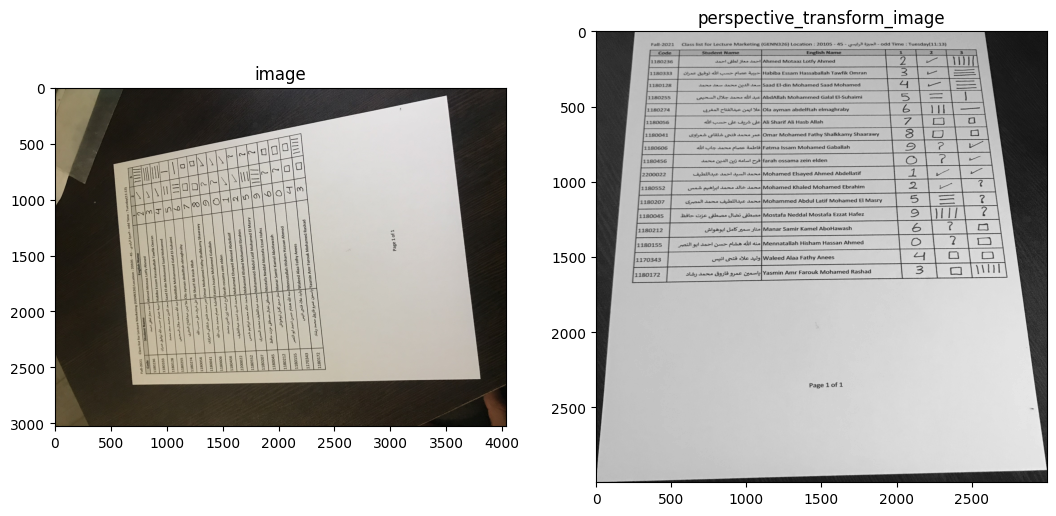

[256, 2866, 202, 3804]


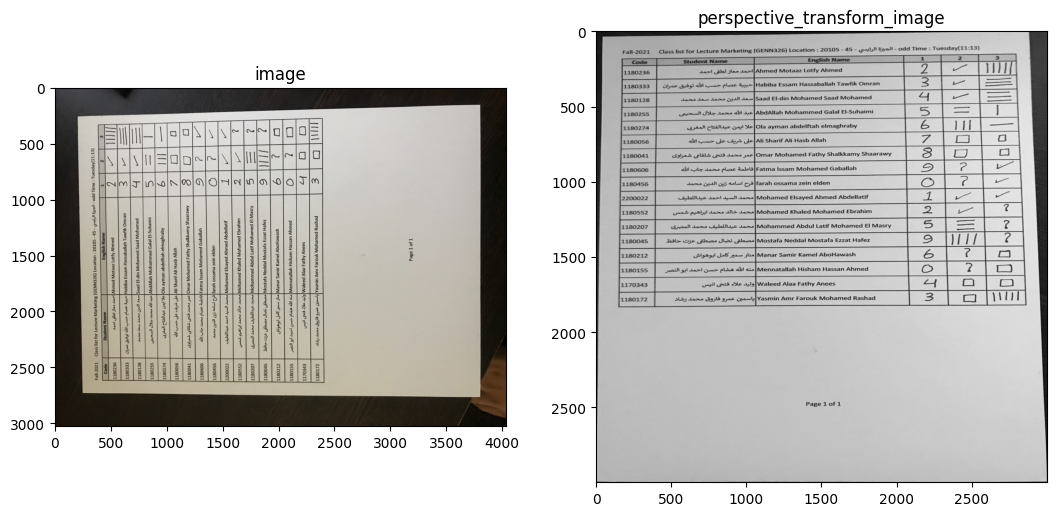

[162, 2888, 236, 3719]


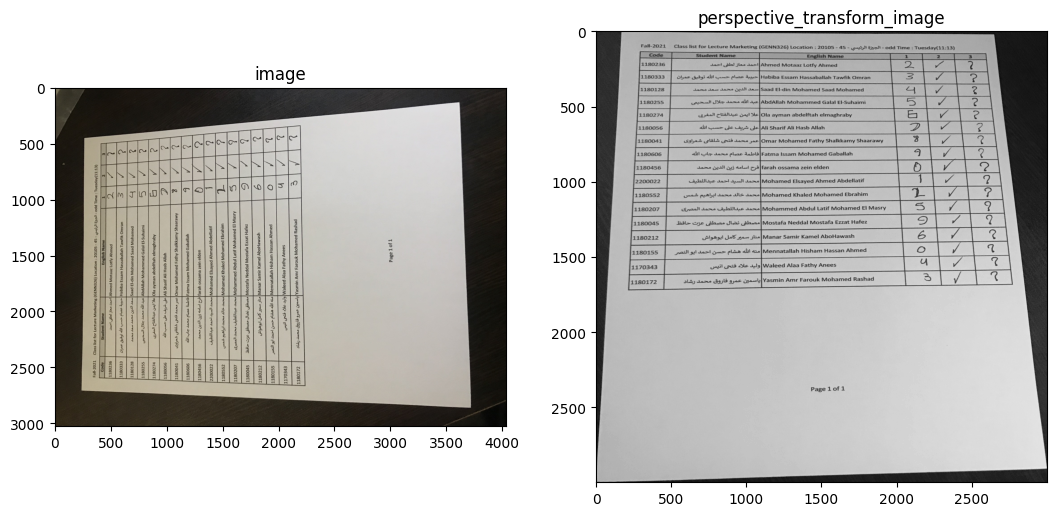

In [6]:

def perspective_transform_image(img):
    # Read the image
    image = np.copy(img)
    
    # get the source points 
    image = deskew_image(image)
    box, mask = draw_contours(image)
    [xmin, xmax, ymin, ymax]= box 

    # Convert the image to grayscale
    gray_image = color.rgb2gray(image)

    source_points = np.array( [[0, 0] ,[3000, 0 ] ,[0, 3000] ,[3000 ,3000]] )

    # Define the destination points (a rectangle)
    destination_points = np.array([[xmin, ymin],  [xmax, ymin], [xmin,ymax], [xmax, ymax]])

    # Estimate the perspective transform
    tform = transform.ProjectiveTransform()
    tform.estimate(source_points, destination_points)

    # Apply the perspective transformation to the image
    transformed_image = transform.warp(gray_image, tform, output_shape=(3000, 3000))

    return transformed_image


for i in range(1,5):
    image = io.imread('grade_sheet/{}.jpg'.format(i))

    show_images([image,perspective_transform_image(image)], ['image', 'perspective_transform_image'])